## Tutorial 4: off-line learning the Q-values of the Kennedy receiver ##

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random


def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn

def ps_maxlik(beta):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    p=0
    for n1 in [0,1]:
       p+=Prob(np.sign(beta)*(-1)**(n1)*alpha, beta, n1)
    return p/2


### what we wanna learn ###

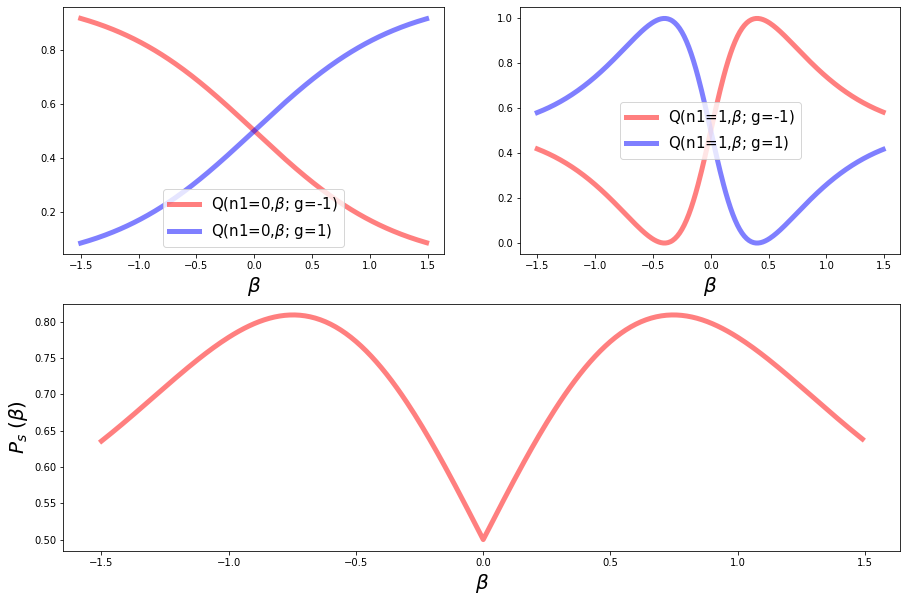

In [2]:


plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((2,2),(0,0))
ax2 =  plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

betas = np.arange(-1.5,1.5,.01)
ax3.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red", linewidth=5)
ax3.set_xlabel(r'$\beta$', size=20)
ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


### So we create the dataset, notice now we return almost pre-processed ###

In [3]:
class DataSet():
    def __init__(self, size=10**3, nbetas=10,rpbgo=-1, creation_mode = "TrueSampling"):
        #rpbgo = rewards per beta-guess-outcome
        self.size = size
        self.amplitude = 0.4
        step = np.round(3/nbetas,3)
        self.betas = np.arange(-1.5, 1.5+step,step)
        self.rpbgo = rpbgo

        if creation_mode == "TrueSampling":
            self.data_unsplitted=self.create_dataset_true_sampling()
        elif creation_mode == "Uniform":
            self.data_unsplitted=self.create_dataset_uniform_sampling()

    def create_dataset_true_sampling(self):
        d=[]
        for repetitions in range(self.size):
            ph = np.random.choice([-1.,1.],1)[0]
            beta = np.random.choice(self.betas,1)[0]
            proboutcome = Prob(ph*self.amplitude,beta,0)
            outcome = np.random.choice([0.,1.],1,p=[proboutcome, 1-proboutcome])[0]
            guess = np.random.choice([-1.,1.],1)[0]
            mean_bernoulli = qval(beta, outcome, guess)
            if guess == ph:
                reward = 1
            else:
                reward = 0
            #reward = np.random.choice([1.,0.,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
            d.append([beta,outcome,guess,reward])
        return np.array(d)
    
    def create_dataset_uniform_sampling(self):
        if self.rpbgo!=-1:
            self.size = 4*nbetas*rpbgo
        d=[]
        #for episode in range(size):
        for b in self.betas:
            for outcome in [0.,1,]:
                for guess in [-1.,1.]:
                    for k in range(self.rpbgo):
                        mean_bernoulli = qval(b, outcome, guess)
                        reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
                        d.append([b, outcome, guess, reward])

    
    
    def sample_minibatch(self, bs):
        #samples a minibatch of full history of transitions: a0 -> h0 -> a1 -> h1 -> r2.
        #returns a random sample of {a0}, {h1-a1}, {r2} ordered!
        d = self.data_unsplitted[np.random.choice(np.arange(self.size),int(bs),replace=False)]
        a0s = d[:,0]
        h0s_a1s = d[:,[0,1,2]]
        r2s = d[:,3]
        return a0s, h0s_a1s, r2s
    
    def pre_process(self, data):
        data_prep = []
        for ind, d in enumerate(data):
            a0s = d[:,0]
            h0s_a1s = d[:,[0,1,2]]
            r2s = d[:,3]
            data_prep.append([a0s, h0s_a1s, r2s])
        return data_prep
    
    
    def give_epoch(self, bs):
        #gives a list of batches that form an epoch
        epoch=[]
        data = self.data_unsplitted.copy()
        np.random.shuffle(data)
        data = self.BatchSizeSplit(data, bs)[0]
        data = self.pre_process(data)
        return data
        #for k in range(int(self.siz|e/bs)):
         #   epoch.append(self.sample_minibatch(bs))
        #return epoch
    
    def BatchSizeSplit(self, dataset,batch_size):
        
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])


### Let's see if things are done well.. ###

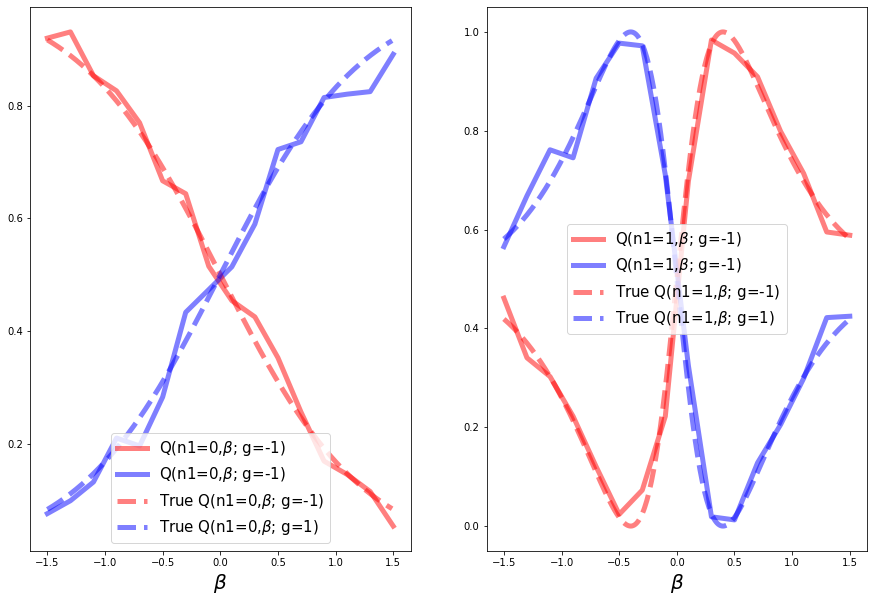

In [6]:
dataset = DataSet(size=10**4, nbetas=15)

histo = {}
number = {}
for k in dataset.betas:
    for g in [-1.,1.]:
        for outcome in [0.,1.]:
            
            histo[str(k)+"n"+str(outcome)+"g"+str(g)] = 0
            number[str(k)+"n"+str(outcome)+"g"+str(g)] = 1

for dato in dataset.data_unsplitted:
    histo[str(dato[0])+"n"+str(dato[1])+"g"+str(dato[2])] += dato[3]
    number[str(dato[0])+"n"+str(dato[1])+"g"+str(dato[2])] += 1
    
for k in dataset.betas:
    for g in [-1.,1.]:
        for outcome in [0.,1.]:
            histo[str(k)+"n"+str(outcome)+"g"+str(g)] /=number[str(k)+"n"+str(outcome)+"g"+str(g)] 


plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas_train = dataset.betas
ax1.plot(dataset.betas,[histo[str(b)+"n0.0g-1.0"] for b in betas_train],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(dataset.betas,[histo[str(b)+"n0.0g1.0"] for b in betas_train],alpha=0.5,c="blue", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

ax2.plot(dataset.betas,[histo[str(b)+"n1.0g-1.0"] for b in betas_train],alpha=0.5,c="red", linewidth=5, label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(dataset.betas,[histo[str(b)+"n1.0g1.0"] for b in betas_train],alpha=0.5,c="blue", linewidth=5, label="Q(n1=1,"+r'$\beta$'+"; g=-1)")

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],'--',alpha=0.5,c="red", linewidth=5, label="True Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],'--',alpha=0.5,c="blue",  linewidth=5,label="True Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],'--',alpha=0.5,c="red",  linewidth=5,label="True Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],'--',alpha=0.5,c="blue",  linewidth=5,label="True Q(n1=1,"+r'$\beta$'+"; g=1)")



#ax1.plot(dataset.beas,[mean_values[str(b)]["1"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

#ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
#ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


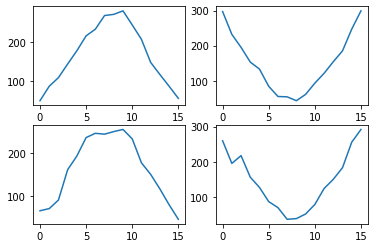

In [7]:
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0))
ax4 = plt.subplot2grid((2,2),(1,1))

axx = {"0": ax1, "1": ax2, "2":ax3, "3":ax4}
index=0
for g in [-1.,1.]:
    for outcome in [0.,1.]:
        axx[str(index)].plot([number[str(k)+"n"+str(outcome)+"g"+str(g)] for k in dataset.betas], label=str(g)+str(outcome))
        index+=1

### Define the networks ###

In [8]:

class Net(tf.keras.Model):
    #input_dim: 1 if layer=0, 3 if layer= 2, for the Kennedy receiver ##
    def __init__(self, input_dim, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(input_dim,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
    def update_target_parameters(self,primary_net, tau=0.01):
        #### only 
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(tau * prim_weights[i] + (1 - tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


### this function may be crazy, but it's just to plot the predictions of the second network ##

In [9]:
def plot_predictions(histo_preds, losses, betas, title=None):

    plt.figure(figsize=(25,20))
    ax1 =  plt.subplot2grid((2,3),(0,0))
    ax2 =  plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(1,0), colspan=2)
    ax4 = plt.subplot2grid((2,3),(0,2))
    ax5 = plt.subplot2grid((2,3),(1,2))

    ax1.plot(betas,[qval(b, 0, -1) for b in betas],'--',alpha=0.85,c="red", linewidth=8, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],'--',alpha=0.85,c="blue",  linewidth=8,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],'--',alpha=0.85,c="red",  linewidth=8,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],'--',alpha=0.85,c="blue",  linewidth=8,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,[ps_maxlik(b) for b in betas],'--',alpha=0.85,c="purple", linewidth=8)
    ax3.set_xlabel(r'$\beta$', size=20)
    ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

    betas_train = betas
    for predictions in histo_preds["net_1"].values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=8)#), label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="purple", linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="purple",s=150)
    
    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="purple",linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="purple",s=150)

    
    ### we do the same for ax3:
    
    for predictions in histo_preds["net_0"].values():
        ax3.plot(betas_train,predictions["values"],alpha=0.15, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")

    #The last one black and bigger!
    ax3.plot(betas_train,predictions["values"],alpha=0.85,"black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")


    for ax in [ax1, ax2,ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
        
     #### not plot the losses"####   
    for ax, loss in zip([ax4,ax5],losses):
        ax.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

        ax.set_xlabel("epoch", size=20)
        ax.set_ylabel("Loss",size=20)
    return

In [10]:
def calculate_greedy_from_batch(net_1, batch):
    a = batch[1].copy()
    preds1 = net_1(a)
    a[:,2] = -a[:,2]
    preds2 = net_1(a)
    both = tf.concat([preds1,preds2],1)
    maxs = np.squeeze(tf.math.reduce_max(both,axis=1))
    maxs = np.expand_dims(maxs, axis=1)
    return maxs


In [11]:
def supervised_training(batch_size=32., total_epochs=30, buffer_size=10**4, tau=0.0005, lr=0.001):

    net_0 = Net(input_dim=1)
    net_1 = Net(input_dim=3)
    net_1_target = Net(input_dim=3)

    net_0(np.array([[0.],[1.]])) #initialize the network 0, arbitrary inputs.
    net_1(np.array([[0.,1.,1.]]))
    net_1_target(np.array([[0.,1.,1.]]))

    optimizer_0 = tf.keras.optimizers.Adam(lr=lr)
    optimizer_1 = tf.keras.optimizers.Adam(lr=lr)

    dataset = DataSet(size=10**4, nbetas=15)
    histo_preds = {"net_0":{}, "net_1":{}} #here i save the predictions

    loss_0_ev, loss_1_ev = [], []
    for epoch_number in tqdm(range(total_epochs)):
        epoch = dataset.give_epoch(batch_size)
        loss_0_avg, loss_1_avg = [], []
        for batch in epoch:
            labels_net0 = calculate_greedy_from_batch(net_1_target, batch ) #greedy from target!
            labels_net1 = np.expand_dims(batch[2],axis=1)
            with tf.GradientTape() as tape:
                tape.watch(net_0.trainable_variables)
                preds0 = net_0(np.expand_dims(batch[0],axis=1))
                loss_0 = tf.keras.losses.MSE(labels_net0,preds0)
                loss_0 = tf.reduce_mean(loss_0)
                grads0 = tape.gradient(loss_0, net_0.trainable_variables)
                optimizer_0.apply_gradients(zip(grads0, net_0.trainable_variables))
                
            with tf.GradientTape() as tape:
                tape.watch(net_1.trainable_variables)
                preds1 = net_1(batch[1])
                loss_1 = tf.keras.losses.MSE(labels_net1,preds1)
                loss_1 = tf.reduce_mean(loss_1)
                grads1 = tape.gradient(loss_1, net_1.trainable_variables)
                optimizer_1.apply_gradients(zip(grads1, net_1.trainable_variables))
            loss_0_avg.append(loss_0)
            loss_1_avg.append(loss_1)
            net_1_target.update_target_parameters(net_1, tau=tau)

        ### save the average losses per epoch###
        mean_loss_0 = np.mean(loss_0_avg)
        mean_loss_1 = np.mean(loss_1_avg)
        loss_0_ev.append(mean_loss_0)
        loss_1_ev.append(mean_loss_1)

        ### save the network's prediction at each epoch ###
        for nett in ["net_0","net_1"]:

            histo_preds[nett][str(epoch_number)] ={} 
            histo_preds[nett][str(epoch_number)]["epoch_number"] = epoch_number
            histo_preds[nett][str(epoch_number)]["values"] = {}

        histo_preds["net_0"][str(epoch_number)]["values"] = np.squeeze(net_0(np.expand_dims(dataset.betas,axis=1)))

        index=0
        for n1 in [0.,1.]:
            for guess in [-1.,1.]:
                foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                histo_preds["net_1"][str(epoch_number)]["values"][str(index)] = np.squeeze(net_1(foo))
                index+=1
        if epoch_number%max(1,int(total_epochs/10)) ==0:
            #plot_predictions(histo_preds, [loss_0_ev, loss_1_ev], dataset.betas)
            print("#### \nepoch: {}\nloss_0: {}\nloss_1: {}\n \n***********\n".format(epoch_number,mean_loss_0,mean_loss_1))
    losses = [loss_0_ev, loss_1_ev]
    return histo_preds, losses, dataset.betas

In [12]:
histo_preds, losses, betas = supervised_training(batch_size=500, total_epochs=100,
                                                 buffer_size=5*10**4,tau=0.001)

#### 
epoch: 0
loss_0: 2.831273619176753e-06
loss_1: 0.250080176834807
 
***********

#### 
epoch: 10
loss_0: 1.4473043081642507e-07
loss_1: 0.19549826432633263
 
***********

#### 
epoch: 20
loss_0: 2.2439101243450459e-07
loss_1: 0.18973125574338795
 
***********

#### 
epoch: 30
loss_0: 1.4923325422375839e-05
loss_1: 0.1883130839360444
 
***********

#### 
epoch: 40
loss_0: 6.499333859936603e-05
loss_1: 0.1874293614316622
 
***********

#### 
epoch: 50
loss_0: 0.0002064984529954003
loss_1: 0.1866493874750982
 
***********

#### 
epoch: 60
loss_0: 0.000519599075268484
loss_1: 0.18664488459772524
 
***********

#### 
epoch: 70
loss_0: 0.0010321469249907295
loss_1: 0.18640120844413882
 
***********

#### 
epoch: 80
loss_0: 0.0016893302116674444
loss_1: 0.18633784252465635
 
***********

#### 
epoch: 90
loss_0: 0.002363973980363989
loss_1: 0.18635250774309606
 
***********




W0403 12:02:05.496503 140118253225792 legend.py:1282] No handles with labels found to put in legend.


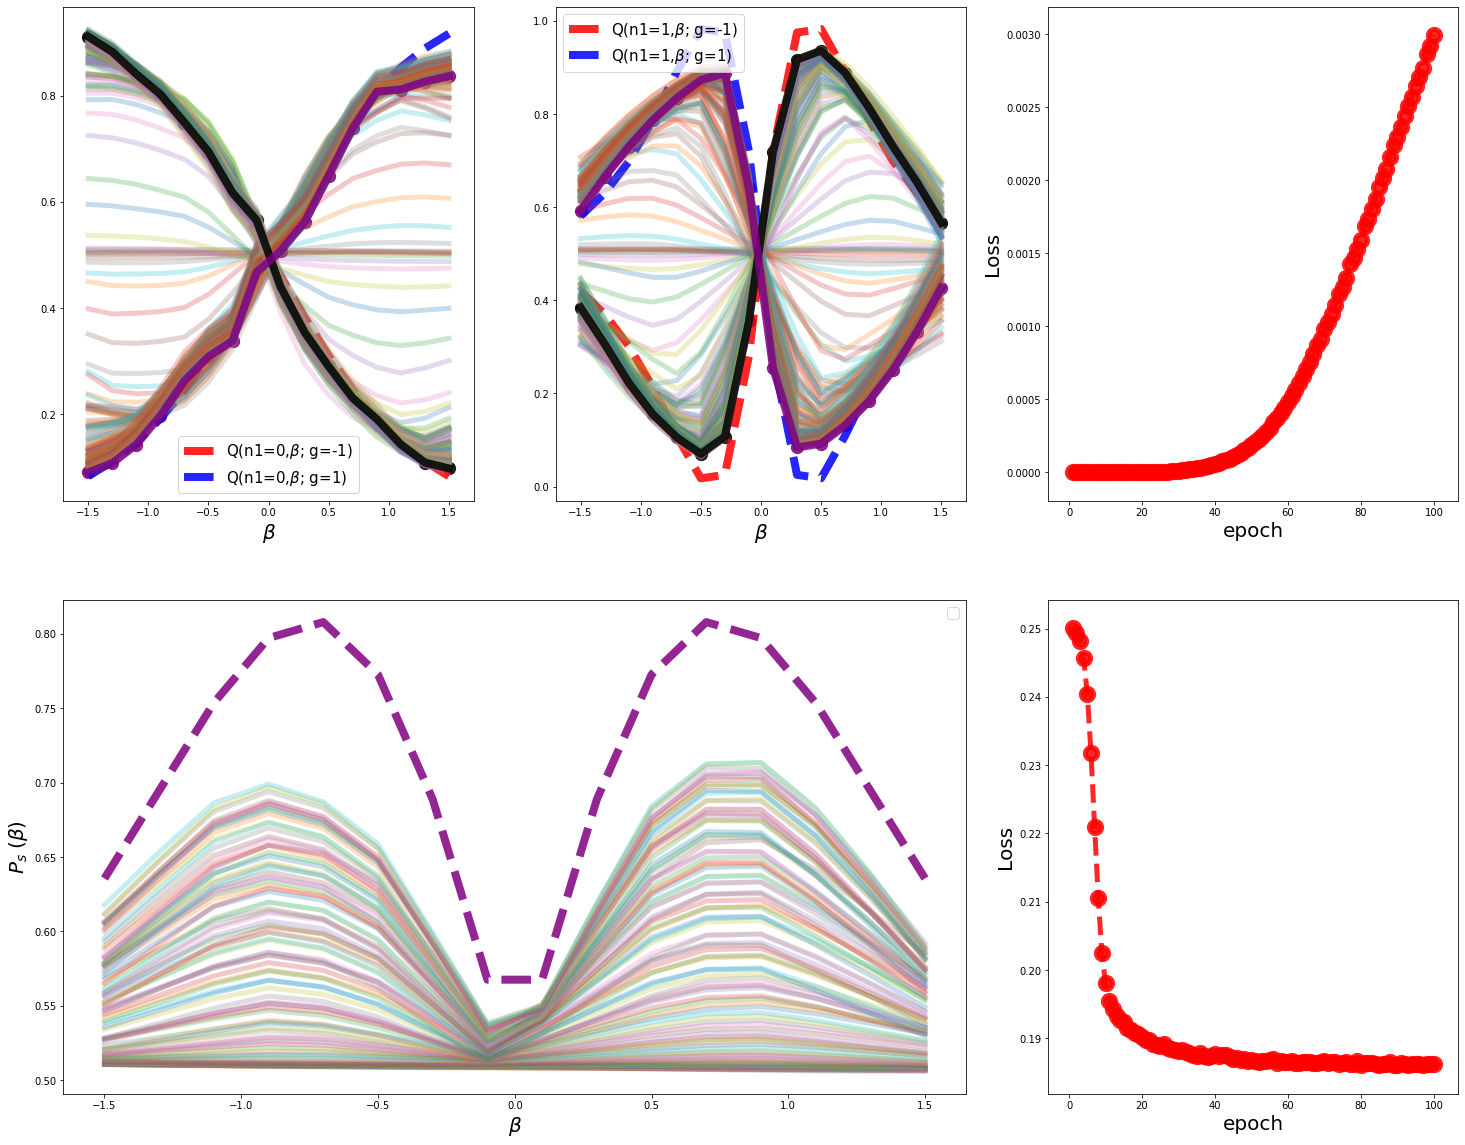

In [13]:
plot_predictions(histo_preds,losses,betas)

In [14]:
histo_preds, losses, betas = supervised_training(batch_size=500, total_epochs=100,
                                                 buffer_size=5*10**4,tau=0.01)

#### 
epoch: 0
loss_0: 0.0002059091436384441
loss_1: 0.24976507549436225
 
***********

#### 
epoch: 10
loss_0: 0.0006234870884079071
loss_1: 0.19631592554062338
 
***********

#### 
epoch: 20
loss_0: 0.0023768298394512112
loss_1: 0.1898961601211866
 
***********

#### 
epoch: 30
loss_0: 0.004543845848609831
loss_1: 0.18807955455962677
 
***********

#### 
epoch: 40
loss_0: 0.0058252308885024485
loss_1: 0.18843959658395085
 
***********

#### 
epoch: 50
loss_0: 0.006651851100345038
loss_1: 0.1876174845582171
 
***********

#### 
epoch: 60
loss_0: 0.006948428176346897
loss_1: 0.18735956692889832
 
***********

#### 
epoch: 70
loss_0: 0.00711264603607067
loss_1: 0.18718435220348997
 
***********

#### 
epoch: 80
loss_0: 0.007134320205928203
loss_1: 0.1868218932035003
 
***********

#### 
epoch: 90
loss_0: 0.007263278151163066
loss_1: 0.18723932482448077
 
***********




W0403 12:03:54.972821 140118253225792 legend.py:1282] No handles with labels found to put in legend.


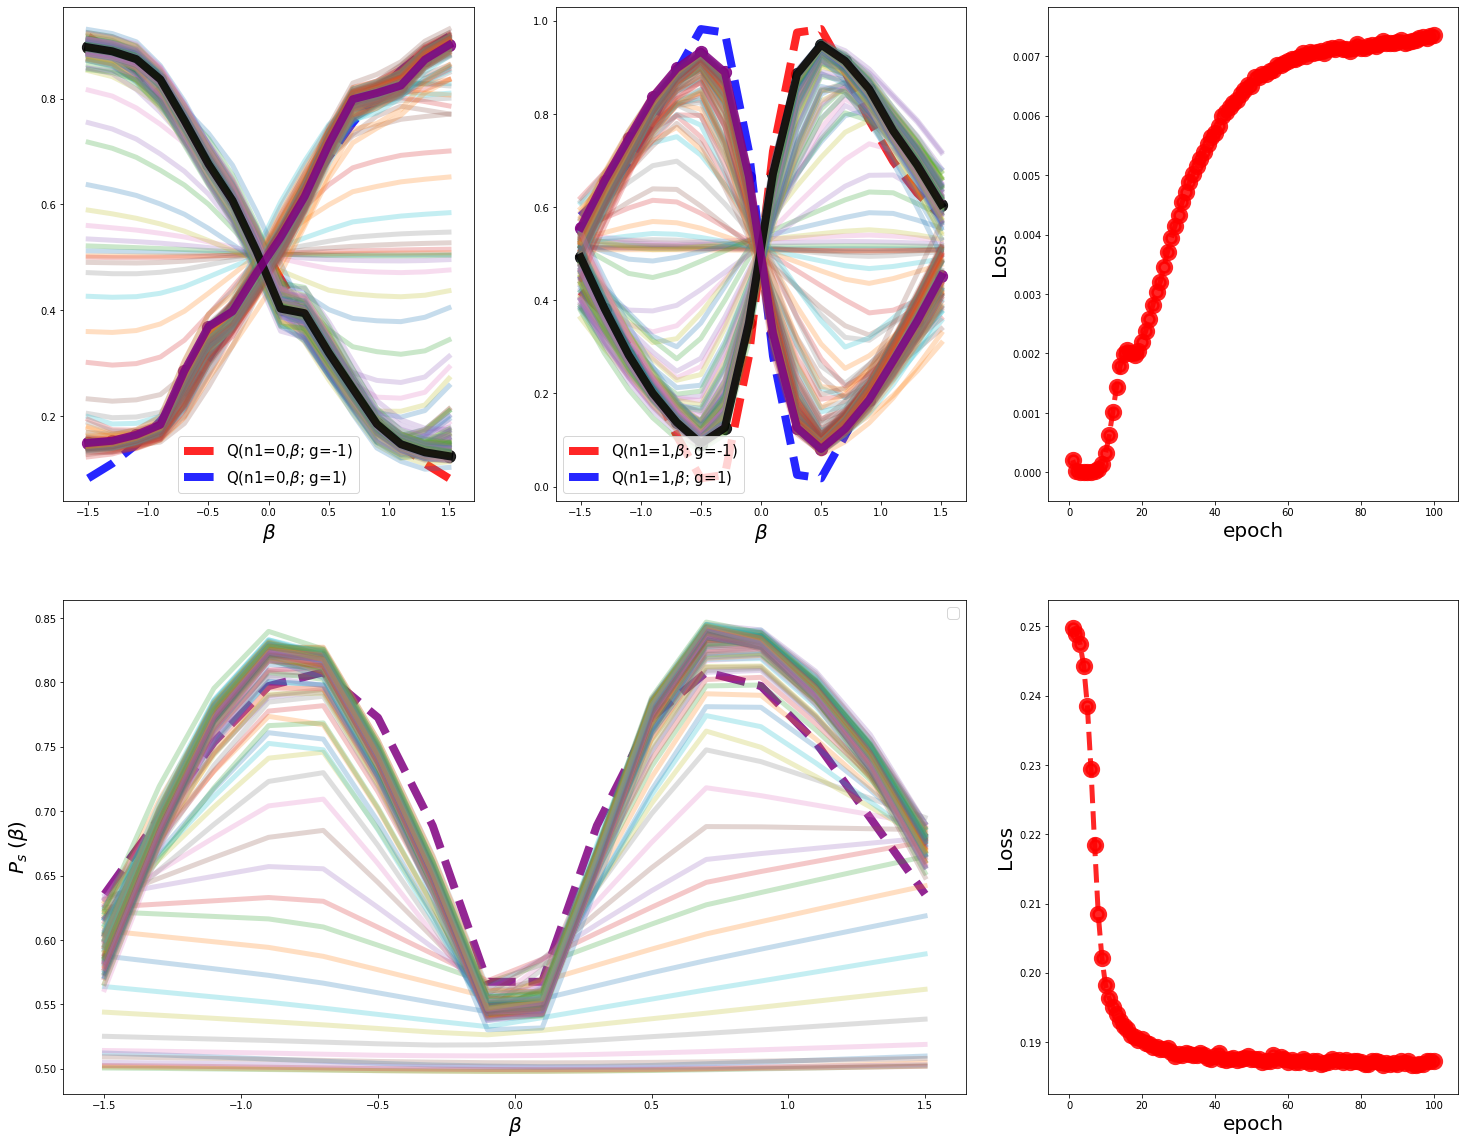

In [15]:
plot_predictions(histo_preds,losses,betas)

In [16]:
histo_preds, losses, betas = supervised_training(batch_size=500, total_epochs=300,
                                                 buffer_size=5*10**4,tau=0.0005)


#### 
epoch: 0
loss_0: 6.489674141048948e-07
loss_1: 0.24978067739257184
 
***********

#### 
epoch: 30
loss_0: 2.1235555822192693e-07
loss_1: 0.19147707815656698
 
***********

#### 
epoch: 60
loss_0: 5.7392298232096376e-05
loss_1: 0.19040678909485328
 
***********

#### 
epoch: 90
loss_0: 0.0004531960948436535
loss_1: 0.18977653330568067
 
***********

#### 
epoch: 120
loss_0: 0.0013904576726517972
loss_1: 0.18961706383503107
 
***********

#### 
epoch: 150
loss_0: 0.0028494673416353516
loss_1: 0.18988241104325526
 
***********

#### 
epoch: 180
loss_0: 0.004338144692991241
loss_1: 0.18981312670930933
 
***********

#### 
epoch: 210
loss_0: 0.005575527616283302
loss_1: 0.18914124714797548
 
***********

#### 
epoch: 240
loss_0: 0.006534611219584538
loss_1: 0.18947120656342664
 
***********

#### 
epoch: 270
loss_0: 0.007241650454492298
loss_1: 0.1896290420595058
 
***********




W0403 12:07:19.988105 140118253225792 legend.py:1282] No handles with labels found to put in legend.


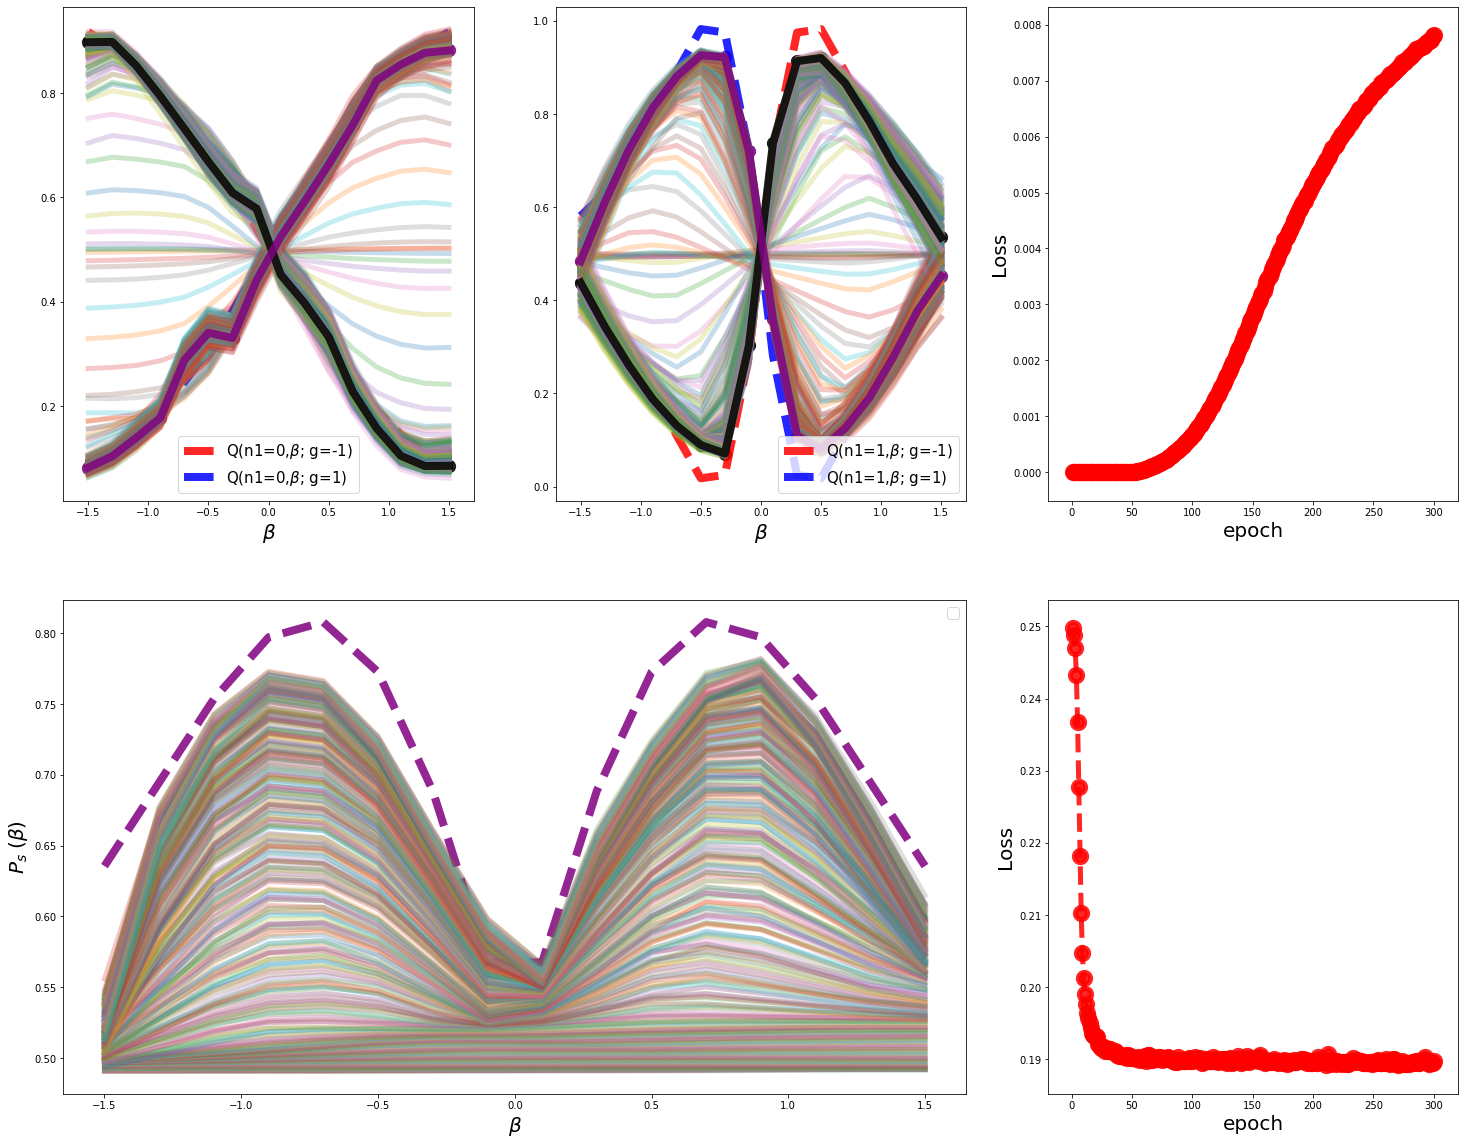

In [17]:
plot_predictions(histo_preds,losses,betas)

In [19]:
histo_preds, losses, betas = supervised_training(batch_size=50, total_epochs=300,
                                                 buffer_size=5*10**4,tau=0.0005)


#### 
epoch: 0
loss_0: 9.197432749448517e-05
loss_1: 0.241580221703799
 
***********

#### 
epoch: 30
loss_0: 0.004368877815052012
loss_1: 0.18639049344313569
 
***********

#### 
epoch: 60
loss_0: 0.006361543154935975
loss_1: 0.18609590400558612
 
***********

#### 
epoch: 90
loss_0: 0.006765161939535091
loss_1: 0.1859719765414921
 
***********

#### 
epoch: 120
loss_0: 0.007105000886862818
loss_1: 0.1856883935589915
 
***********

#### 
epoch: 150
loss_0: 0.007633073396665136
loss_1: 0.18546734946124172
 
***********

#### 
epoch: 180
loss_0: 0.008200077212863822
loss_1: 0.18520077904158896
 
***********

#### 
epoch: 210
loss_0: 0.008565311760950284
loss_1: 0.18535204319876808
 
***********

#### 
epoch: 240
loss_0: 0.008806076436233686
loss_1: 0.18498953822199762
 
***********

#### 
epoch: 270
loss_0: 0.008959651725507192
loss_1: 0.18499715971679204
 
***********




W0403 12:27:41.657238 140118253225792 legend.py:1282] No handles with labels found to put in legend.


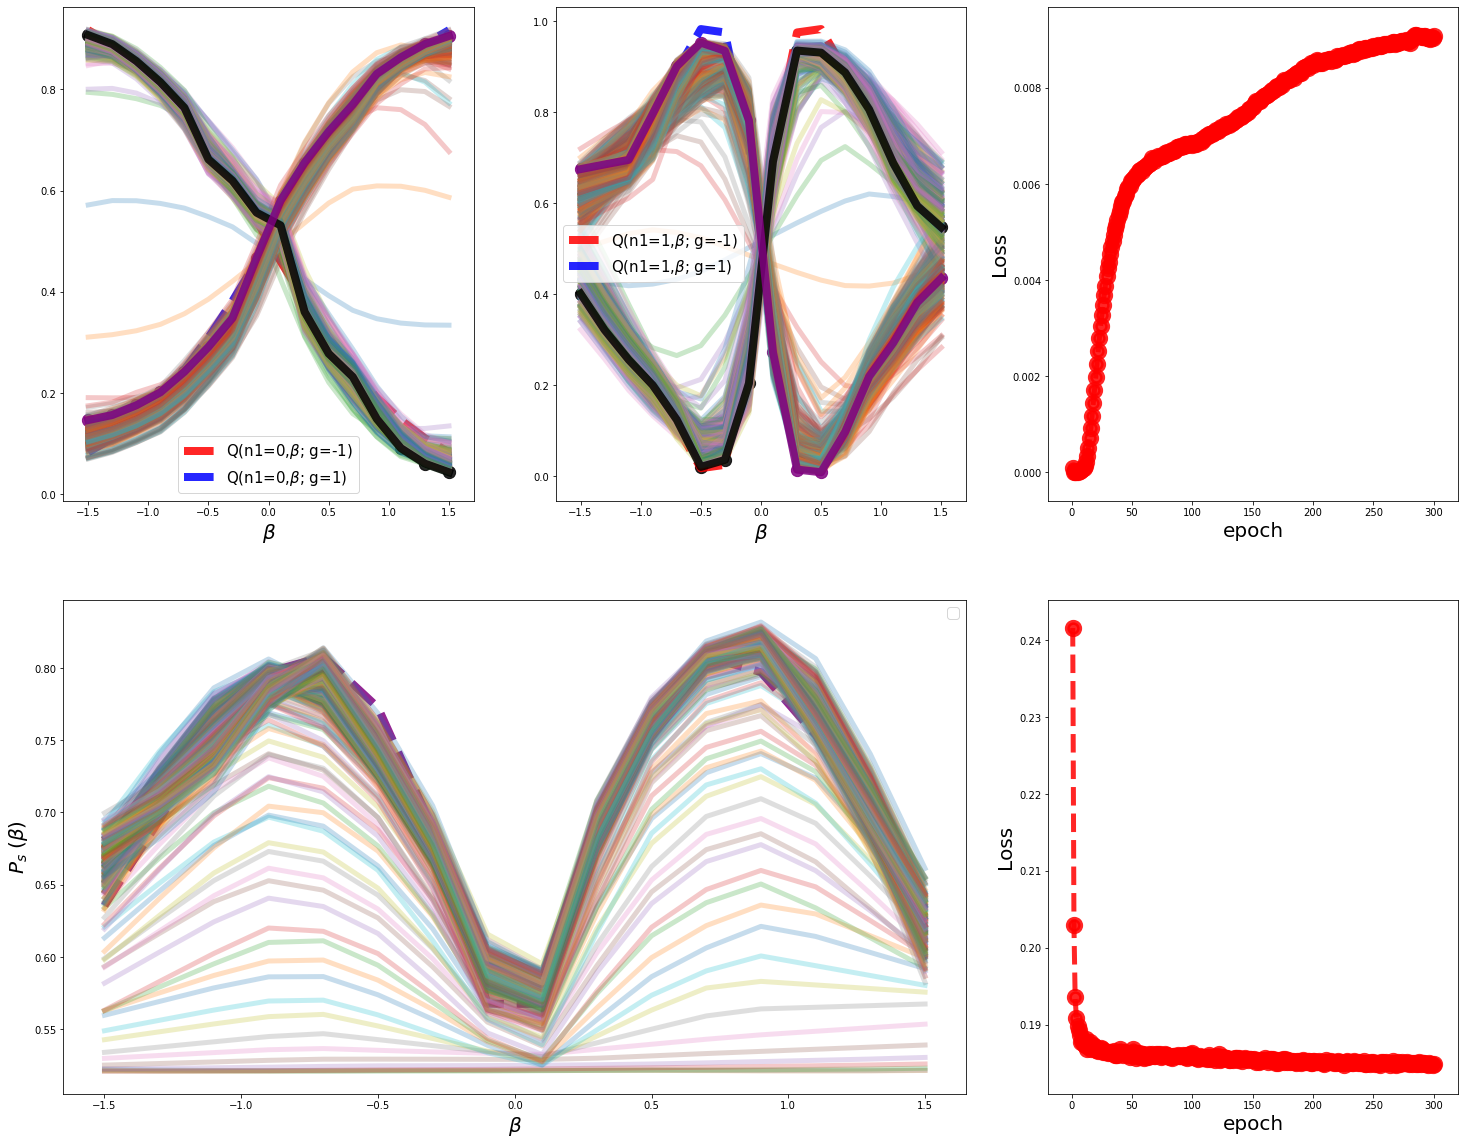

In [20]:
plot_predictions(histo_preds,losses,betas)

#### 
epoch: 0
loss_0: 0.0010993057217109615
loss_1: 0.22828434614890394
 
***********

#### 
epoch: 3
loss_0: 0.004319270265837639
loss_1: 0.19376410882437226
 
***********

#### 
epoch: 6
loss_0: 0.006115595947214367
loss_1: 0.19190156795370086
 
***********

#### 
epoch: 9
loss_0: 0.006709504866546389
loss_1: 0.19174739331768414
 
***********

#### 
epoch: 12
loss_0: 0.007210329248260672
loss_1: 0.1912228016951839
 
***********

#### 
epoch: 15
loss_0: 0.007807553453554313
loss_1: 0.19133829927666962
 
***********

#### 
epoch: 18
loss_0: 0.007709004275727258
loss_1: 0.19021825802870482
 
***********

#### 
epoch: 21
loss_0: 0.00823418511376633
loss_1: 0.19057448811673267
 
***********

#### 
epoch: 24
loss_0: 0.008049473143674357
loss_1: 0.1899883110110865
 
***********

#### 
epoch: 27
loss_0: 0.008400253598621581
loss_1: 0.19001105573270088
 
***********




W0403 12:37:58.077109 140118253225792 legend.py:1282] No handles with labels found to put in legend.


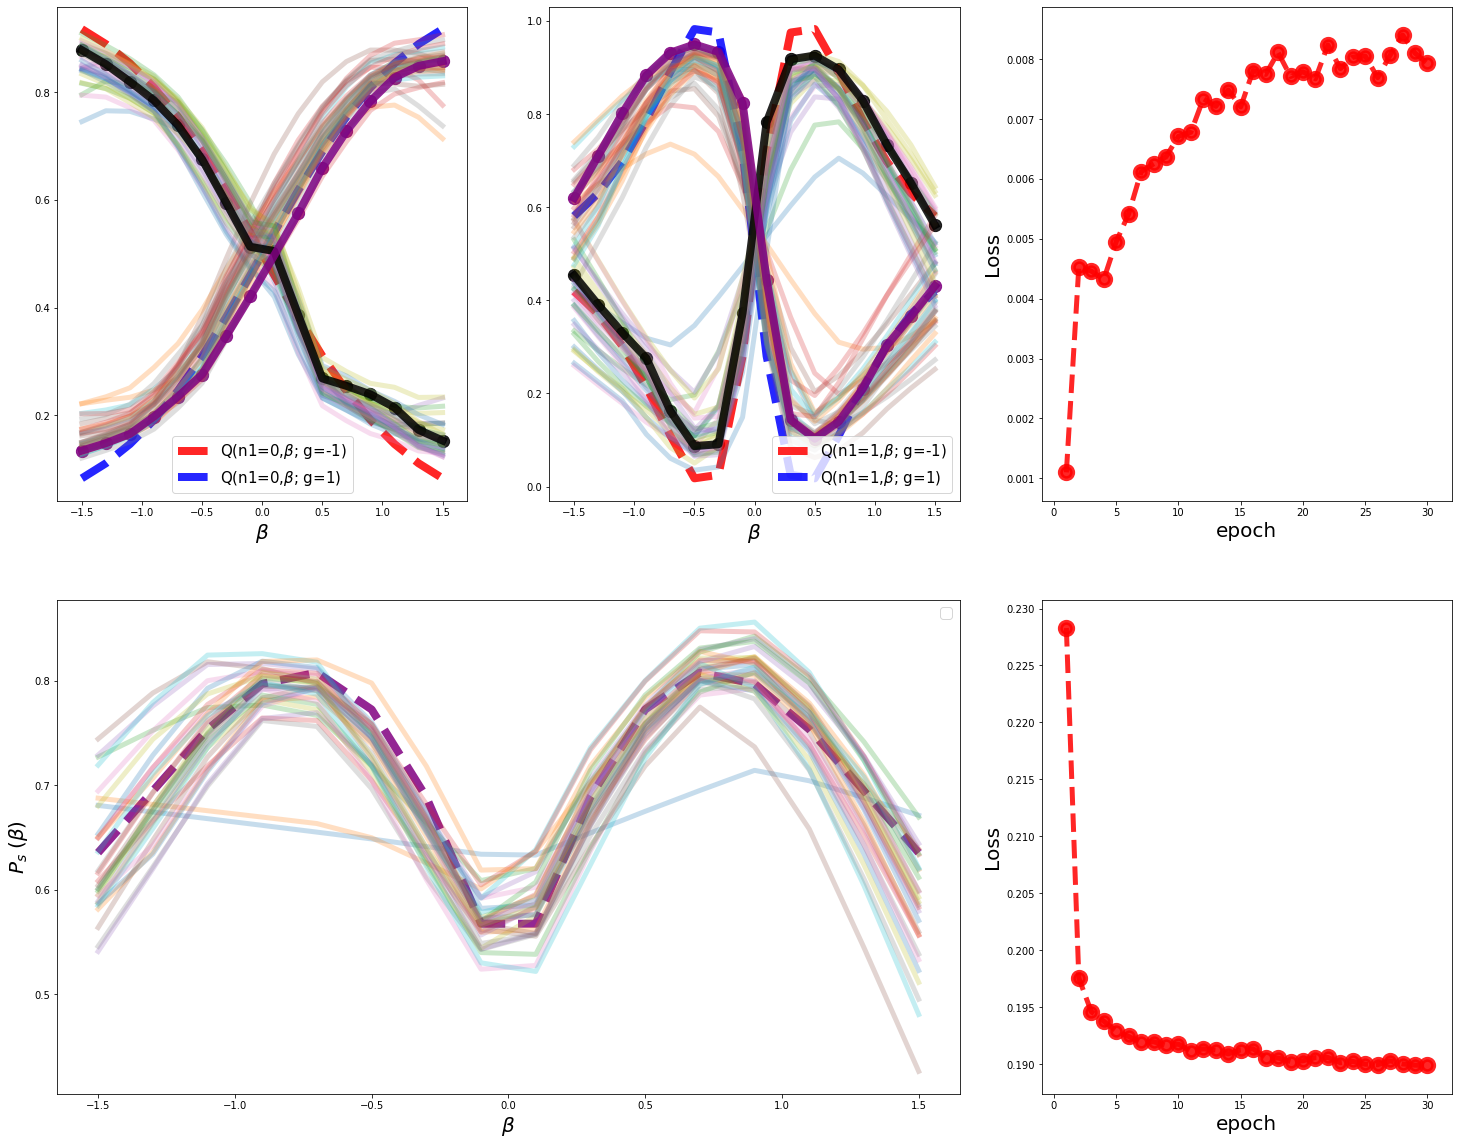

In [21]:
histo_preds, losses, betas = supervised_training(batch_size=16, total_epochs=30,
                                                 buffer_size=5*10**4,tau=0.1, lr=0.001)
plot_predictions(histo_preds,losses,betas)

W0403 12:38:13.157305 140118253225792 legend.py:1282] No handles with labels found to put in legend.


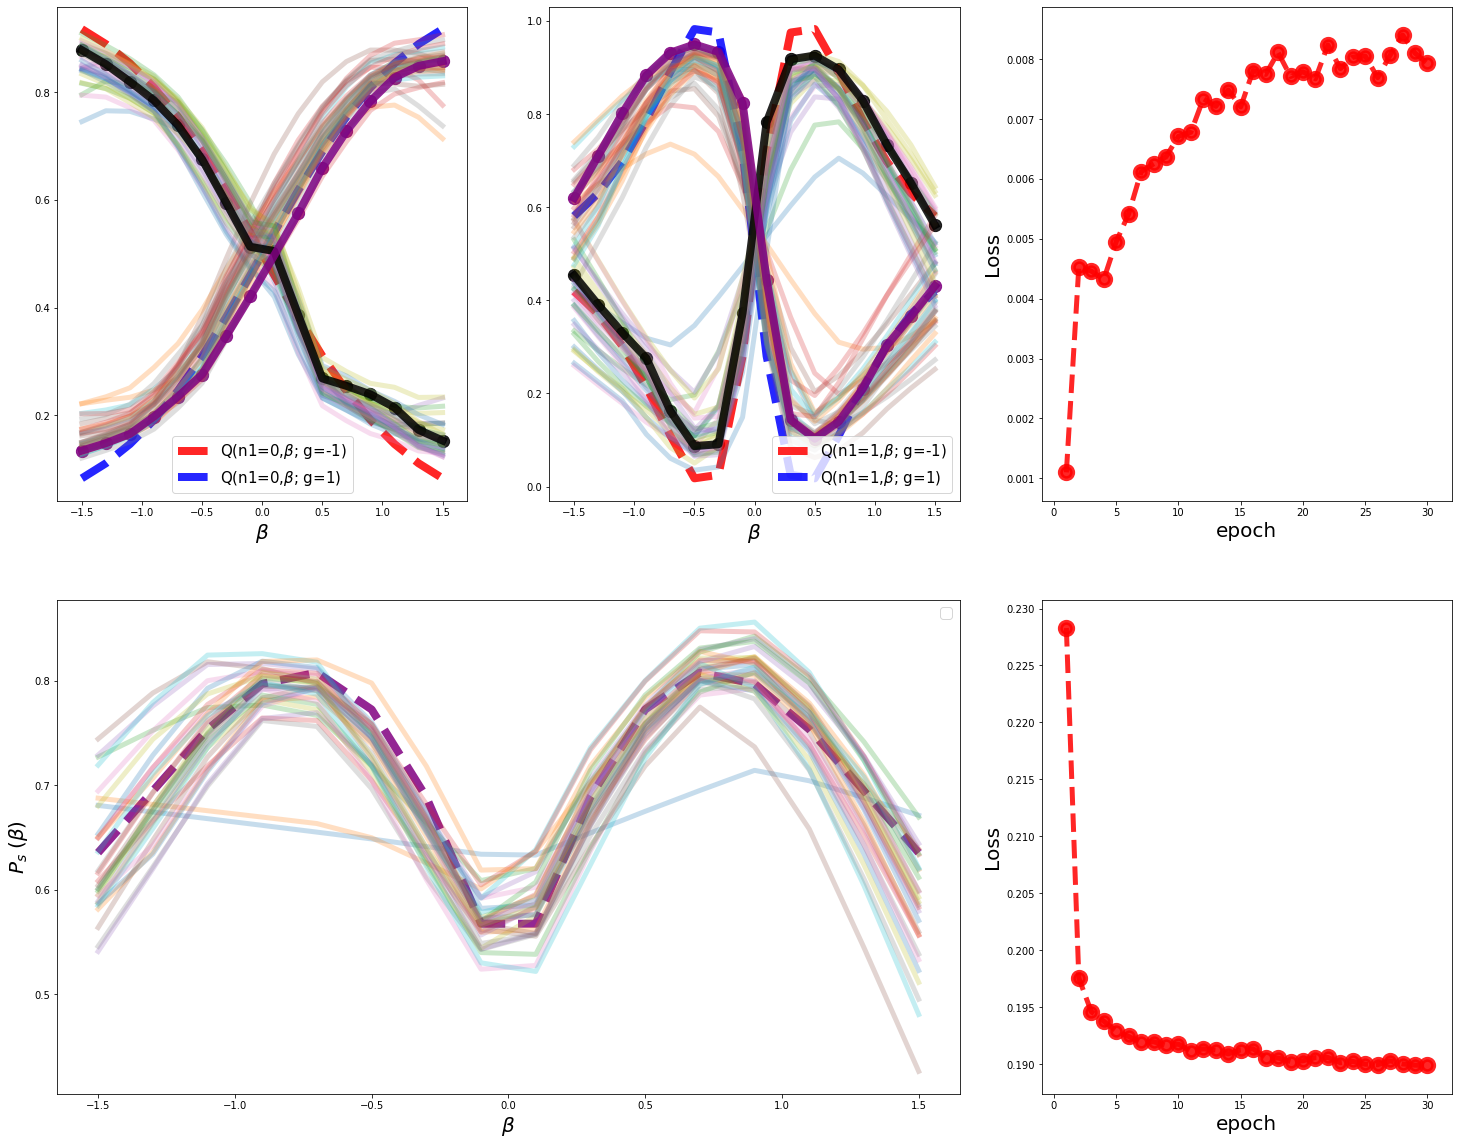

In [22]:
plot_predictions(histo_preds,losses,betas)

In [53]:
data = dataset.data_unsplitted

In [54]:
import pandas as pd

In [55]:
data = pd.DataFrame(data)

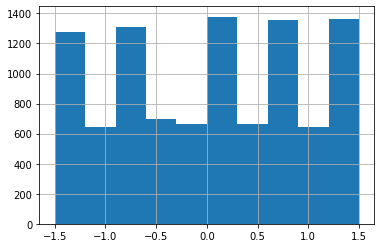

In [56]:
data.iloc[:,0].hist()

In [59]:
betas = data.to_numpy()[:,0]

In [60]:
for b in dataset.betas:
    if 
    number[str(b)] 

array([-1.5       , -1.28571429, -1.07142857, -0.85714286, -0.64285714,
       -0.42857143, -0.21428571,  0.        ,  0.21428571,  0.42857143,
        0.64285714,  0.85714286,  1.07142857,  1.28571429,  1.5       ])

In [65]:
cont=np.zeros(len(dataset.betas))
for k in range(len(dataset.betas)):
    cont[k]=len(np.where(betas == dataset.betas[k])[0])

In [68]:
np.std(cont)

25.14137802287076

In [81]:
histo.keys()

dict_keys(['-1.5n0.0g-1.0', '-1.5n1.0g-1.0', '-1.5n0.0g1.0', '-1.5n1.0g1.0', '-1.2857142857142858n0.0g-1.0', '-1.2857142857142858n1.0g-1.0', '-1.2857142857142858n0.0g1.0', '-1.2857142857142858n1.0g1.0', '-1.0714285714285714n0.0g-1.0', '-1.0714285714285714n1.0g-1.0', '-1.0714285714285714n0.0g1.0', '-1.0714285714285714n1.0g1.0', '-0.8571428571428572n0.0g-1.0', '-0.8571428571428572n1.0g-1.0', '-0.8571428571428572n0.0g1.0', '-0.8571428571428572n1.0g1.0', '-0.6428571428571429n0.0g-1.0', '-0.6428571428571429n1.0g-1.0', '-0.6428571428571429n0.0g1.0', '-0.6428571428571429n1.0g1.0', '-0.4285714285714286n0.0g-1.0', '-0.4285714285714286n1.0g-1.0', '-0.4285714285714286n0.0g1.0', '-0.4285714285714286n1.0g1.0', '-0.2142857142857144n0.0g-1.0', '-0.2142857142857144n1.0g-1.0', '-0.2142857142857144n0.0g1.0', '-0.2142857142857144n1.0g1.0', '0.0n0.0g-1.0', '0.0n1.0g-1.0', '0.0n0.0g1.0', '0.0n1.0g1.0', '0.2142857142857142n0.0g-1.0', '0.2142857142857142n1.0g-1.0', '0.2142857142857142n0.0g1.0', '0.2142857142

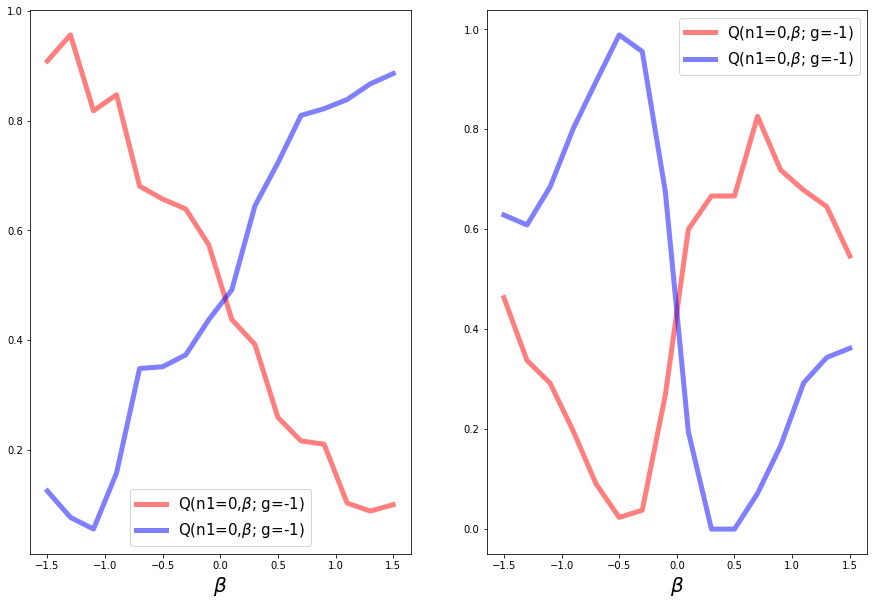